In this version, use Anthony's set up for P0YP0 P1YP1, and implement concurrent VQE

In [311]:
%run SetUp.ipynb

from scipy.optimize import minimize

In [312]:
import cmath

In [355]:
nQ = 6
LL = nQ

## Define VQE form

In [333]:
# VQE
# "state" is the state PYP acts on. Implementing this way to not have to generate an entire matrix and save running time. 
# odd layer theta0*POYPO theta1*P1YP1 then even layer

def PYP(angle1,angle2, nq,state):
    n_sets = int(nq/2)
    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0),state) 
        state = sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1),state)
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0),state)
        state =  sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1),state)
    return state


In [334]:

# Generate Fake Vacuum
# version that generates [[1,0,...]] and has dimension issues:  
#  fake_vac = ft.reduce(sp.sparse.kron, [[1,0]]* nq)

#fake_vac = sp.sparse.csr_array(np.ndarray.flatten(ft.reduce(sp.sparse.kron, [[1,0]]* nq).toarray()))

def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray(),dtype = np.cfloat).transpose()

## Set up function to minimize and initial points

In [358]:
num_params = 2
fake_vac_nQ = fake_vac(nQ) # predefine to save runtime

In [336]:

# activate 1 site. 

def activate1(init,loc,nq): # init is a function of nq, init(nq) is a state, loc is which link is activated
    #P0XP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),x,sp.sparse.identity(2**(nq-loc-1))]) 
    return act_mat @ init(nq)

#### Concurrent VQE

In [337]:
import h5py

In [357]:
# for 6 qubits
# with h5py.File('/Users/zhiyaoli/IQuS Dropbox/Zhiyao Li/String Breaking/Data/eigenstates.h5', 'r') as f:

# for 8 qubits # we are not doing VQE for 20 qubits
with h5py.File('/Users/zhiyaoli/IQuS Dropbox/Zhiyao Li/String Breaking/Data/eigenstates.h5', 'r') as f:
    data = f['Dataset1'][:]

In [339]:
data.shape

(15, 16384)

In [361]:
meson_p_full = []

for i in range(len(data)-1):
    real_part = data[i]["Re"]
    imag_part = data[i]["Im"]
    complex_data = real_part + 1j * imag_part
    meson_p_full.append(complex_data)

real_part = data[-1]["Re"]
imag_part = data[-1]["Im"]
vac_full = real_part + 1j * imag_part    

In [341]:
p_list = [(2*math.pi/LL)*(index+1) -math.pi for index in range(nQ)]

In [342]:
p_list[int(LL/2)-1]

0.0

In [343]:
### Define cost function to maximize state fidelities for Concurrent VQE

LL = nQ # 2L = nQ
# vac_full and meson_p_full are the eigenstates of the full Hamiltonian.

def cost_func(angles):
    angle1, angle2 = angles[0], angles[1]    
    
    vac_state = PYP(angle1,angle2,nQ,fake_vac_nQ) 
    
    meson_overlap = 0
    for index in range(LL): # p goes from -Pi*(l-1)/L to Pi
       # if index == int(LL/2)-1: # skipping the p = 0 case
       #     continue
        
        p = p_list[index]
        
        # Sum over x to get |p>
        mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray(), dtype = np.cfloat).transpose()
        for xx in range(nQ):
            meson_state = activate1(fake_vac,xx,nQ)
            mesons += cmath.exp(1j*p*xx) * meson_state
            
        meson_p = PYP(angle1,angle2,nQ,mesons/math.sqrt(LL)) 
        meson_overlap += overlap(meson_p_full[index],meson_p)**2
    
    return 1-(overlap(vac_full,vac_state)**2 + meson_overlap)

In [344]:
initial_point = np.random.rand(num_params)

In [345]:
cost_func(initial_point)

-4.66579285513168

In [346]:
cost_func([0.17805,0.0795])

-2.8776396292794346

In [347]:
cost_func([-0.17923051, -0.10247442])

-12.984998923558171

In [348]:
initial_point

array([0.12558217, 0.73550113])

## Run VQE

#### nelder-mead

In [330]:
res = minimize(cost_func, initial_point, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: -10.987846
         Iterations: 81
         Function evaluations: 164


In [331]:
print(res.x)

[-0.17871452 -0.10364305]


#### powell

In [349]:
res2 = minimize(cost_func, initial_point, method='powell',
               options={'disp': True})

Optimization terminated successfully.
         Current function value: -12.985062
         Iterations: 3
         Function evaluations: 90


In [350]:
print(res2.x)

[-0.17853036 -0.10245756]


#### BFGS

In [275]:
res3 = minimize(cost_func,initial_point, method='BFGS', tol = 1e-8,
               options={'disp': True})

# tol = 1e-8,
# xatol = 1e-8,

         Current function value: 10.006849
         Iterations: 10
         Function evaluations: 42
         Gradient evaluations: 14


/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [276]:
print(res3.x)

[-0.17939731 -0.10569839]


## Test

#### Concurrent VQE check

In [363]:
scipy_angles = [-0.17939731, -0.10569839]
scipy_results = np.reshape(PYP(0.17939731, 0.10569839,nQ,fake_vac_nQ).toarray(),-1)

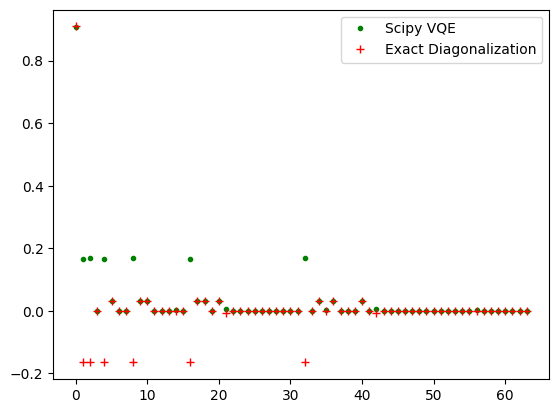

In [364]:
plt.plot(list(range(2**nQ)), scipy_results,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ)),-vac_full,'r+',label = 'Exact Diagonalization')
plt.legend()

In [285]:
for index in range(nQ):
    mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray()).transpose()
    p = p_list[index]
    for xx in range(nQ):
        meson_state = activate1(fake_vac,xx,nQ)
        mesons += cmath.exp(1j*p*xx) * meson_state
    meson_p = PYP(-0.17929116, -0.1060088,nQ,mesons/math.sqrt(LL)) 
    print(f"index: {index} , Overlap {overlap(meson_p_full[index],meson_p)**2}, p: {p}")

index: 0 , Overlap 0.999115660104633, p: -2.356194490192345
index: 1 , Overlap 0.9998577811240188, p: -1.5707963267948966
index: 2 , Overlap 0.9985772107568545, p: -0.7853981633974483
index: 3 , Overlap 2.2582938417334174e-05, p: 0.0
index: 4 , Overlap 0.9985772107568545, p: 0.7853981633974483
index: 5 , Overlap 0.9998577811240188, p: 1.5707963267948966
index: 6 , Overlap 0.999115660104633, p: 2.356194490192345
index: 7 , Overlap 0.9981374166933965, p: 3.141592653589793


In [286]:
def get_meson_p_prob(index):
    p = p_list[index]
    mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray()).transpose()
    for xx in range(nQ):
        meson_state = activate1(fake_vac,xx,nQ)
        mesons += cmath.exp(1j*p*xx) * meson_state
    state = PYP(-0.17988941, -0.10526204,nQ,mesons/math.sqrt(LL))
    # state = PYP(-0.17988941, -0.10526204,nQ,fake_vac_nQ)
    return np.abs(state)**2

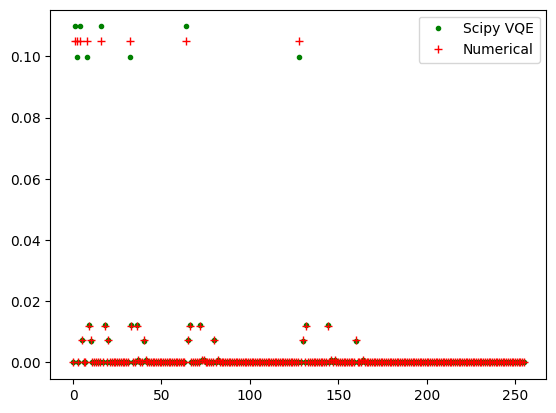

In [287]:
which_p = 0
plt.plot(list(range(2**nQ)), np.reshape(get_meson_p_prob(which_p).toarray(),-1),'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ)), np.abs(meson_p_full[which_p])**2,'r+',label = 'Numerical')
plt.legend()

In [288]:
np.abs(np.array(meson_p_full[2]).conj().T @ np.array(meson_p_full[-1]))

4.751527617475582e-16

## Extrapolate angles

In [ ]:
# for 6 qubits removing p0 fidelity in cost function
# angles_from_vqe = [-0.17929116, -0.1060088]


# not removing p0 fidelity in cost function 
# 6 qubits [-0.18010458, -0.10601949]
# 8 qubits [-0.17939733, -0.10569892]
# 10 qubits [-0.17898116, -0.10476864]
# 12 qubits [-0.17871452, -0.10364305] changed to minimizing 1-fidelity instead of nq - fidelity
# 14 qubits [-0.17853036, -0.10245756]

# 20 qubit angles based on Anthony's plot
# angles_from_vqe = [0.1781, 0.10]

Exponential fit: a=0.18107195494370584, b=-0.002140049807961762


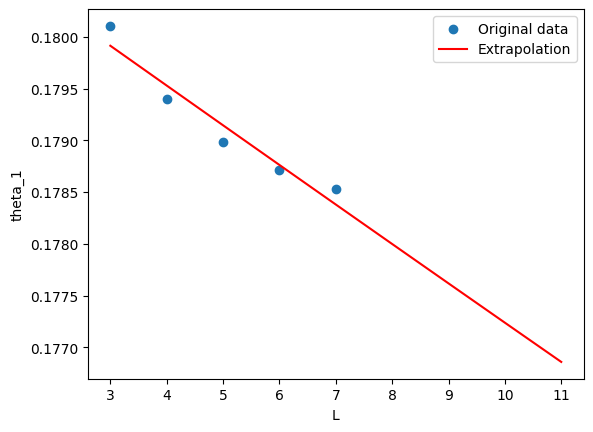

In [365]:
from matplotlib.pylab import f
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample data
L_data = np.array([3,4,5,6,7])
theta_1_data = np.array([0.18010458,0.17939733,0.17898116,0.17871452,0.17853036])
theta_2_data = np.array([0.10601949,0.10569892,0.10476864,0.10364305,0.10245756])

# Exponential function to fit
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Fit the data
params, _ = curve_fit(exp_func, L_data, theta_1_data)
a, b = params

# Generate extrapolated data points
x_extrap = np.array([3,4,5,6, 7, 8,9,10,11])
y_extrap = exp_func(x_extrap, a, b)

print(f"Exponential fit: a={a}, b={b}")

# Plot the original data and the extrapolation
plt.scatter(L_data, theta_1_data, label='Original data')
plt.plot(x_extrap, y_extrap, 'r', label='Extrapolation')
plt.xlabel('L')
plt.ylabel('theta_1')
plt.legend()
plt.show()

Exponential fit: c=0.10919236499414982, d=-0.00876660433226213


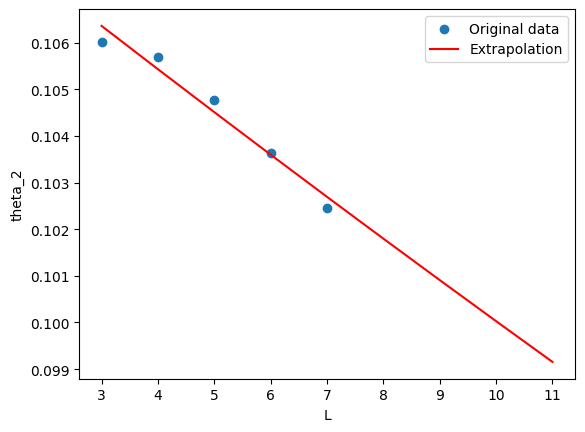

In [ ]:
params, _ = curve_fit(exp_func, L_data, theta_2_data)
c, d = params

# Generate extrapolated data points
x_extrap = np.array([3,4,5,6, 7, 8,9,10,11])
y_extrap = exp_func(x_extrap, c, d)
print(f"Exponential fit: c={c}, d={d}")

# Plot the original data and the extrapolation
plt.scatter(L_data, theta_2_data, label='Original data')
plt.plot(x_extrap, y_extrap, 'r', label='Extrapolation')
plt.xlabel('L')
plt.ylabel('theta_2')
plt.legend()
plt.show()